In [1]:
# ! pip install tqdm yfinance quantstats

In [2]:
import yfinance as yf
import pandas as pd

start = '2006-01-01'
end = '2024-01-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(f'https://www.slickcharts.com/{assets}', storage_options={'User-agent': 'Mozilla/5.0'})
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [3]:
data

AAPL                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2006-01-03    2.585000    2.669643    2.580357    2.669643    2.263001   
2006-01-04    2.683214    2.713571    2.660714    2.677500    2.269662   
2006-01-05    2.672500    2.675000    2.633929    2.656429    2.251801   
2006-01-06    2.687500    2.739286    2.662500    2.725000    2.309928   
2006-01-09    2.740357    2.757143    2.705000    2.716071    2.302358   
...                ...         ...         ...         ...         ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.600006   
2023-12-26  193.610001  193.889999  192.830002  193.050003  193.050003   
2023-12-27  192.490005  193.500000  191.089996  193.149994  193.149994   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.580002   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.529999   

                               MSFT                                      ...  \
                 Volume        Open        High         Low       Close  ...   
Date                                                                     ...   
2006-01-03  807234400.0   26.250000   27.000000   26.100000   26.840000  ...   
2006-01-04  619603600.0   26.770000   27.080000   26.770000   26.969999  ...   
2006-01-05  449422400.0   26.959999   27.129999   26.910000   26.990000  ...   
2006-01-06  704457600.0   26.889999   27.000000   26.490000   26.910000  ...   
2006-01-09  675040800.0   26.930000   27.070000   26.760000   26.860001  ...   
...                 ...         ...         ...         ...         ...  ...   
2023-12-22   37122800.0  373.679993  375.179993  372.709991  374.579987  ...   
2023-12-26   28919300.0  375.000000  376.940002  373.500000  374.660004  ...   
2023-12-27   48087700.0  373.690002  375.059998  372.809998  374.070007  ...   
2023-12-28   34049900.0  375.369995  376.459991  374.160004  375.279999  ...   
2023-12-29   42628800.0  376.000000  377.160004  373.480011  376.040009  ...   

                  WBA                                    SIRI              \
                  Low      Close  Adj Close      Volume  Open  High   Low   
Date                                                                        
2006-01-03  44.340000  45.389999  28.610369   5217300.0  6.81  6.82  6.45   
2006-01-04  43.950001  43.980000  27.721626   5900300.0  6.45  6.50  6.28   
2006-01-05  43.400002  43.580002  27.469486   4568900.0  6.45  6.46  6.35   
2006-01-06  43.220001  43.369999  27.337118   4205500.0  6.50  6.54  6.40   
2006-01-09  43.049999  43.910000  27.677490   4396800.0  6.75  6.76  6.54   
...               ...        ...        ...         ...   ...   ...   ...   
2023-12-22  25.799999  26.219999  26.219999   9776300.0  5.48  5.49  5.39   
2023-12-26  26.200001  26.610001  26.610001  10181100.0  5.45  5.53  5.42   
2023-12-27  26.459999  26.639999  26.639999   8265500.0  5.49  5.57  5.44   
2023-12-28  26.389999  26.600000  26.600000   7899900.0  5.49  5.60  5.49   
2023-12-29  25.750000  26.110001  26.110001  10853300.0  5.52  5.52  5.42   

                                        
           Close Adj Close      Volume  
Date                                    
2006-01-03  6.52  5.691051  72062300.0  
2006-01-04  6.36  5.551394  63817600.0  
2006-01-05  6.39  5.577580  44321100.0  
2006-01-06  6.54  5.708509  42477400.0  
2006-01-09  6.57  5.734695  73075200.0  
...          ...       ...         ...  
2023-12-22  5.47  5.470000   8635000.0  
2023-12-26  5.50  5.500000   7249000.0  
2023-12-27  5.48  5.480000   8919800.0  
2023-12-28  5.53  5.530000   7115700.0  
2023-12-29  5.47  5.470000   8542800.0  

[4536 rows x 606 columns]

In [7]:
from btlib import Strategy

def EMA(ser: pd.Series, period: int):
    return ser.ewm(span=period, adjust=False).mean().values

class MACrossoverStrategy(Strategy):
    buy_at_once_size = .01 # 1%

    def init(self, fast_period: int, slow_period: int):
        self.fast_ma = {}
        self.slow_ma = {}

        for symbol in self.symbols:
            self.fast_ma[symbol] = EMA(self.data[(symbol,'Close')], fast_period)
            self.slow_ma[symbol] = EMA(self.data[(symbol,'Close')], slow_period)

    def next(self, i, record):
        for symbol in self.symbols:
            if self.fast_ma[symbol][i-1] > self.slow_ma[symbol][i-1]:
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=self._positionSize(record[(symbol,'Open')]))

        for position in self.open_positions[:]:
            if self.fast_ma[position.symbol][i-1] < self.slow_ma[position.symbol][i-1]:
                self.close(position=position, price=record[(position.symbol,'Open')])

    def _positionSize(self, price: float):
        return round((self.cash + self.cash_stock_value) / price * self.buy_at_once_size) if price > 0 else 0

In [8]:
from btlib import Backtest
backtest = Backtest(MACrossoverStrategy, data, commission=.001, cash=1e6)

In [9]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Fast MA','Slow MA']
values = [[5, 10, 15, 20, 25], [30, 35, 40, 45, 50]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


In [ ]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Fast MA Slow MA                                                         
25      45          1.004972e+06       6.425533e+07        -41.895239   
        50          1.005008e+06       6.279774e+07        -45.098289   
20      50          1.004972e+06       5.074263e+07        -39.502980   
25      40          1.004972e+06       5.019849e+07        -40.191287   
15      40          1.005513e+06       4.532751e+07        -41.422967   
        30          1.005513e+06       4.321576e+07        -40.627555   
        45          1.005062e+06       4.302307e+07        -40.312580   
25      35          1.004972e+06       4.190327e+07        -38.328053   
15      35          1.005513e+06       3.926459e+07        -42.355167   
20      35          1.004973e+06       4.006021e+07        -41.777320   
        30          1.005513e+06       3.945769e+07        -41.086457   
15      50          1.005062e+06       4.114060e+07        -39.648240   
10      40          1.005513e+06       3.791432e+07        -42.707735   
        45          1.005602e+06       3.666591e+07        -42.816674   
20      45          1.004972e+06       3.972945e+07        -39.915154   
5       35          1.005510e+06       3.387868e+07        -46.344532   
20      40          1.005062e+06       3.834001e+07        -38.462559   
10      50          1.005602e+06       3.544444e+07        -42.940408   
25      30          1.004973e+06       3.593805e+07        -37.966563   
5       30          1.005164e+06       2.975511e+07        -49.464758   
10      35          1.005642e+06       2.921766e+07        -42.200223   
5       50          1.005578e+06       2.833708e+07        -42.112589   
        40          1.005599e+06       2.552194e+07        -42.766211   
        45          1.005599e+06       2.385323e+07        -44.322874   
10      30          1.005510e+06       2.442581e+07        -45.776296   

                  CAGR (%)  Sharpe Ratio  
Fast MA Slow MA                           
25      45       25.989690      1.126887  
        50       25.828909      1.102197  
20      50       24.347680      1.078836  
25      40       24.273211      1.072026  
15      40       23.566701      1.066208  
        30       23.239572      1.058734  
        45       23.212043      1.040366  
25      35       23.032238      1.039171  
15      35       22.584747      1.038557  
20      35       22.725119      1.031792  
        30       22.618167      1.031645  
15      50       22.906119      1.031482  
10      40       22.346622      1.030225  
        45       22.118622      1.028068  
20      45       22.668606      1.023513  
5       35       21.583954      1.022174  
20      40       22.425595      1.012566  
10      50       21.888942      1.010057  
25      30       21.986885      1.009379  
5       30       20.712623      1.007687  
10      35       20.587244      0.971049  
5       50       20.382804      0.967294  
        40       19.684811      0.952784  
        45       19.235980      0.930022  
10      30       19.393825      0.928141

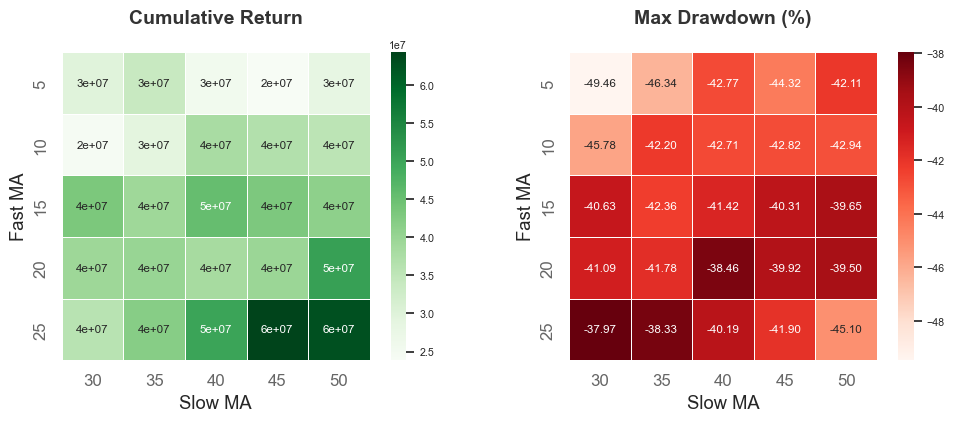

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [ ]:
best_params = optimization_results_sorted.index[0]
best_params

(25, 45)

In [ ]:
result = backtest.run(*best_params)

In [ ]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   6,293.74%   905.52%
CAGR﹪              25.99%      13.68%

Sharpe              1.13        0.69
Prob. Sharpe Ratio  100.0%      99.82%
Sortino             1.62        0.97
Sortino/√2          1.15        0.69
Omega               1.22        1.22

Max Drawdown        -41.9%      -53.85%
Longest DD Days     840         1161

Gain/Pain Ratio     0.22        0.14
Gain/Pain (1M)      1.59        0.83

Payoff Ratio        0.93        0.85
Profit Factor       1.22        1.14
Common Sense Ratio  1.17        1.04
CPC Index           0.64        0.54
Tail Ratio          0.96        0.92
Outlier Win Ratio   3.76        4.19
Outlier Loss Ratio  3.74        4.02

MTD                 6.13%       6.49%
3M                  14.43%      1

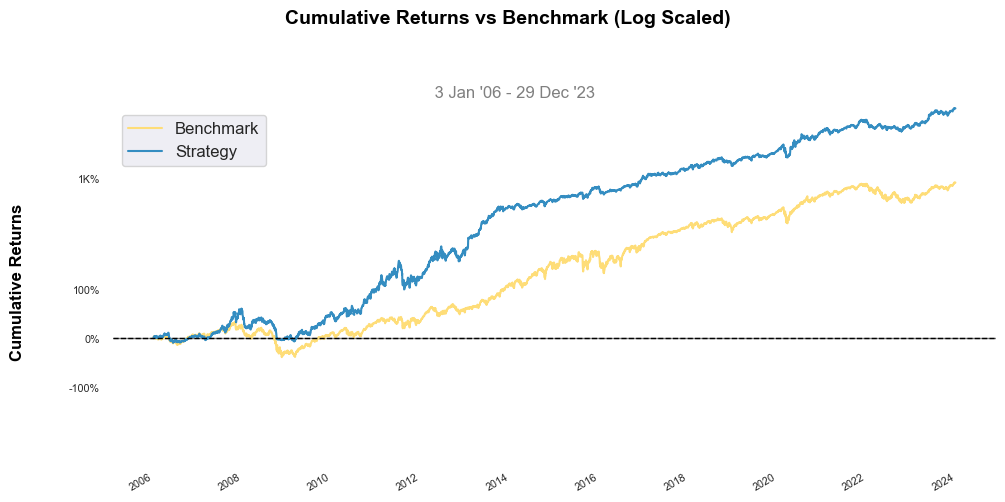

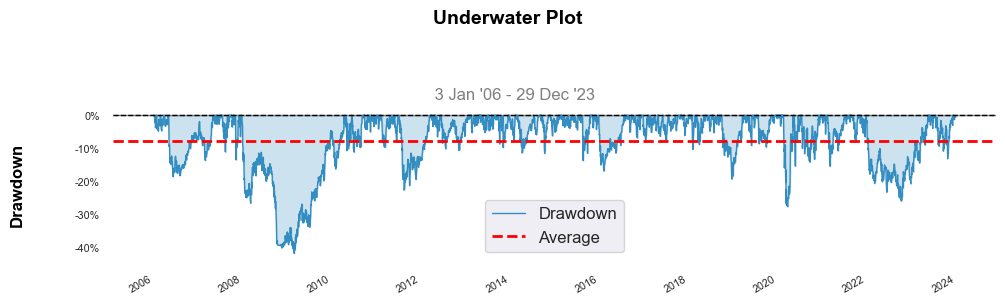

In [ ]:
qs.plots.log_returns(result.returns, benchmark=benchmark)
qs.plots.drawdown(result.returns, figsize=(10,3))

In [ ]:
trades = pd.DataFrame(result.trades)
trades.tail(15)

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
5738,GOOGL,2023-10-05,2023-11-01,135.070007,124.070000,4206,-46266.032089,-8.143931,1089.942870,5.076217e+07
5739,GOOGL,2023-10-20,2023-11-01,137.330002,124.070000,4136,-54843.368835,-9.655576,1081.150406,5.070625e+07
5740,GOOGL,2023-10-23,2023-11-01,135.039993,124.070000,4136,-45371.893494,-8.123515,1071.678931,5.065980e+07
5741,GOOG,2023-10-23,2023-11-01,136.229996,125.339996,4100,-44648.997498,-7.993834,1072.436967,5.061408e+07
5742,GOOGL,2023-10-24,2023-11-01,137.830002,124.070000,4069,-55989.448692,-9.983314,1065.671106,5.055702e+07
5743,GOOG,2023-10-24,2023-11-01,139.160004,125.339996,4030,-55694.629517,-9.931020,1065.935000,5.050026e+07
5744,GOOGL,2023-10-30,2023-11-01,123.209999,124.070000,4352,3742.722656,0.697996,1076.162555,5.050293e+07
5745,GOOG,2023-10-30,2023-11-01,124.459999,125.339996,4309,3791.908165,0.707052,1076.388180,5.050565e+07
5746,GOOGL,2023-10-31,2023-11-01,125.059998,124.070000,4347,-4303.520714,-0.791618,1082.968098,5.050026e+07
5747,GOOG,2023-10-31,2023-11-01,126.269997,125.339996,4306,-4004.581314,-0.736517,1083.432630,5.049517e+07


In [ ]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,SNPS,2022-12-28,2023-12-29,317.820007,514.909973,1214,239267.218506,62.013077,6.251007e+05
1,META,2023-01-11,2023-12-29,130.960007,353.959991,3110,693529.952545,170.280981,1.100816e+06
2,META,2023-01-19,2023-12-29,132.490005,353.959991,3060,677698.157043,167.159768,1.083118e+06
3,META,2023-01-25,2023-12-29,141.220001,353.959991,3003,638858.190674,150.644376,1.062942e+06
4,META,2023-01-30,2023-12-29,149.410004,353.959991,2869,586853.914978,136.905149,1.015511e+06
...,...,...,...,...,...,...,...,...,...
87,EA,2023-11-02,2023-12-29,129.970001,136.809998,4254,29097.344421,5.262750,5.819897e+05
88,AAPL,2023-11-30,2023-12-29,189.839996,192.529999,3199,8605.317810,1.416984,6.159035e+05
89,MSFT,2023-11-30,2023-12-29,378.489990,376.040009,1604,-3929.770630,-0.647304,6.031682e+05
90,AMZN,2023-11-30,2023-12-29,144.759995,151.940002,4195,30120.133286,4.959939,6.373883e+05
